In [1]:
COLLAB = True # False True

In [2]:

if COLLAB:
    !pip install langdetect
    from google.colab import drive
    import pandas as pd
    drive.mount("/content/drive")
    df = pd.read_csv('/content/drive/MyDrive/full_merged_dataset15.csv', encoding='utf-8')

    from IPython.display import HTML, display

    def set_css():
        display(HTML('''
        <style>
            pre {
                white-space: pre-wrap;
            }
        </style>
        '''))
        get_ipython().events.register('pre_run_cell', set_css)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import os
import numpy as np
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt
import html
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import gc
from wordcloud import WordCloud
from gensim.models.phrases import Phrases
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize
import re
import nltk
from sklearn.model_selection import train_test_split
from gensim.matutils import corpus2dense, corpus2csc
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import ast
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud
import spacy
!python -m spacy download en_core_web_md

In [4]:
def check_nltk_packages():
  packages = ['punkt','stopwords','omw-1.4','wordnet']

  for package in packages:
    try:
      nltk.data.find('tokenizers/' + package)
    except LookupError:
      nltk.download(package)
check_nltk_packages()

try:
  import lxml
except ModuleNotFoundError:
  %pip install lxml

try:
  import contractions
except ModuleNotFoundError:
  %pip install contractions
  import contractions

from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Preprocessing

In [5]:
# df = pd.read_csv('Datasets/full_merged_dataset15.csv', encoding='utf-8')
df = df.dropna(subset=['poem'])

In [6]:
df.head()

,id,title,author,snippet,link,categories,poem
0,162275,The 80&rsquo;s Miracle Diet,By Melvin Dixon,Yours free without the asking,https://www.poetryfoundation.org/poetrymagazin...,"['Living', 'Health & Illness']",Yours free without the asking Quick delivery v...
1,162250,All Saints&rsquo;,By Corey Van Landingham,CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin.,https://www.poetryfoundation.org/poetrymagazin...,[],CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin...
2,162279,And These Are Just a Few ...,By Melvin Dixon,This poem is for the epidemic dead and the liv...,https://www.poetryfoundation.org/poetrymagazin...,"['Living', 'Health & Illness', 'Social Comment...",This poem is for the epidemic dead and the liv...
3,162248,ASMR,By Corey Van Landingham,Why not climb up the mountain,https://www.poetryfoundation.org/poetrymagazin...,[],Why not climb up the mountain of delight? To t...
4,162249,ASMR,By Corey Van Landingham,HelloÃ¢â‚¬â€Tonight,https://www.poetryfoundation.org/poetrymagazin...,[],HelloÃ¢â‚¬â€Tonight weÃ¢â‚¬â„¢ll trace the st...


We can remove the id, snippet and link as they are useless for the tasks we have to do.

In [7]:
columns_to_drop = ["id", "snippet", "link"]
df.drop(columns=columns_to_drop, inplace=True)

In [8]:
df.head()

,title,author,categories,poem
0,The 80&rsquo;s Miracle Diet,By Melvin Dixon,"['Living', 'Health & Illness']",Yours free without the asking Quick delivery v...
1,All Saints&rsquo;,By Corey Van Landingham,[],CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin...
2,And These Are Just a Few ...,By Melvin Dixon,"['Living', 'Health & Illness', 'Social Comment...",This poem is for the epidemic dead and the liv...
3,ASMR,By Corey Van Landingham,[],Why not climb up the mountain of delight? To t...
4,ASMR,By Corey Van Landingham,[],HelloÃ¢â‚¬â€Tonight weÃ¢â‚¬â„¢ll trace the st...


In [9]:

def separate_language(df, text_column):
    """
    Separate observations in a DataFrame based on the language detected in a text column.

    Args:
        df (pandas.DataFrame): Input DataFrame.
        text_column (str): Name of the column containing text data.

    Returns:
        tuple: A tuple containing two DataFrames. The first DataFrame contains observations in English,
               and the second DataFrame contains observations in other languages.
    """
    # Initialize lists to store data
    english_data = []
    other_language_data = []

    # Loop through each row in the dataset
    for index, row in df.iterrows():
        text = row[text_column]
        try:
            # Detect language of the text
            lang = detect(text)

            # Append entire row data to respective lists
            if lang == 'en':
                english_data.append(row)
            else:
                other_language_data.append(row)
        except:
            # Handle exceptions in language detection (e.g., short texts)
            pass

    # Create dataframes from lists
    english_df = pd.DataFrame(english_data)
    other_language_df = pd.DataFrame(other_language_data)

    return english_df, other_language_df

In [10]:
# Call the function to separate language
english_df, other_language_df = separate_language(df, 'poem')

In [11]:
# i want to check the size of both dfs
print(english_df.shape)
print(other_language_df.shape)

(44865, 4)
(423, 4)


Only 426 poems are not in english and we know that most of them have been translated to english. Note that this value changes as expected

In [12]:
english_df.head()


,title,author,categories,poem
0,The 80&rsquo;s Miracle Diet,By Melvin Dixon,"['Living', 'Health & Illness']",Yours free without the asking Quick delivery v...
1,All Saints&rsquo;,By Corey Van Landingham,[],CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin...
2,And These Are Just a Few ...,By Melvin Dixon,"['Living', 'Health & Illness', 'Social Comment...",This poem is for the epidemic dead and the liv...
3,ASMR,By Corey Van Landingham,[],Why not climb up the mountain of delight? To t...
4,ASMR,By Corey Van Landingham,[],HelloÃ¢â‚¬â€Tonight weÃ¢â‚¬â„¢ll trace the st...


In [13]:
other_language_df.head()

,title,author,categories,poem
10,Fosfor,By Kacper Bartczak,[],w terrarium jesteÃ…â€º czarna skrzyneczka rzec...
29,PieÃ…â€ºÃ…â€ž tego,By Kacper Bartczak,[],perÃ…â€šo Ã…â€ºwiata wymiocino wieprzu jestem ...
32,Prawda obrazu,By Kacper Bartczak,[],Kobieta naprzeciwko czyta Ã¢â‚¬Å¾NajwiÃ„â„¢ksz...
35,regenportr&auml;t,By Jan Wagner,['Nature'],"erscheint als handkuÃƒÅ¸, als sanfter stubser,..."
37,reifen,By Jan Wagner,"['Social Commentaries', 'Cities & Urban Life']","dort, wo die stadt versickert, beim bahndamm, ..."


### Save the english DataFrame and the rest of the data

In [14]:
english_df.to_csv('english_df.csv', encoding='utf-8', index=False) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used

#other languages dataset can not be codified and as we are not going to use it we dont care about it
other_language_df.to_csv('other_language_df.csv',encoding='utf-8', index=False) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used


# Small Case Text Preprocessing

In [15]:
df = pd.read_csv('english_df.csv', encoding='utf-8')

In [16]:
df.head(5)

,title,author,categories,poem
0,The 80&rsquo;s Miracle Diet,By Melvin Dixon,"['Living', 'Health & Illness']",Yours free without the asking Quick delivery v...
1,All Saints&rsquo;,By Corey Van Landingham,[],CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin...
2,And These Are Just a Few ...,By Melvin Dixon,"['Living', 'Health & Illness', 'Social Comment...",This poem is for the epidemic dead and the liv...
3,ASMR,By Corey Van Landingham,[],Why not climb up the mountain of delight? To t...
4,ASMR,By Corey Van Landingham,[],HelloÃ¢â‚¬â€Tonight weÃ¢â‚¬â„¢ll trace the st...


In [17]:
print(df.shape)


(44865, 4)


As the poems were not well-encoded we have to substitute the bad encoding to an apostrophe (also some other characters), and expand the contractions.

In [18]:
# Pre-compile the patterns for efficiency
url_pattern = re.compile(r'https://\S+|www\.\S+')

chars_to_replace_by_apostrophe = re.compile(r'ÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢|Ã¢â‚¬â„¢|ÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢')
chars_to_replace_by_a = re.compile(r'&aacute')


english_words_pattern = re.compile(r"[a-zA-Z]+'?[a-zA-Z]*")

def wrangle_text(text):

    # Decode HTML entities
    text = html.unescape(text)

    # Remove HTML tags
    text = BeautifulSoup(text, "lxml").text

    # Replace by apostrophe
    text = chars_to_replace_by_apostrophe.sub("'", text)

    # Replace by a
    text = chars_to_replace_by_a.sub('á', text)

    #Extract English words
    english_words = english_words_pattern.findall(text)
    text = ' '.join(english_words)

    # Expand contractions once, after all substitutions
    text = contractions.fix(text)

    return text


In [19]:
poem = df['poem'].iloc[24] # This is the 26th poem
wrangled_poem = wrangle_text(poem)
print(colored('\n============= First poem in corpus =============', 'blue'))
print(poem)
print(colored('\n============= After wrangling result =============', 'green'))
print(wrangled_poem)


============= First poem in corpus =============
Alongside Kara WalkerÃ¢â‚¬â„¢s Ã¢â‚¬Å“Wokey Wokey,Ã¢â‚¬Â 2021 Ã¢â‚¬â€ as i was saying your (idea of) death ainÃ¢â‚¬â„¢t mine(s) i(Ã¢â‚¬â„¢ll) sprout any how (flourish!) your rot Ã‚Â Ã‚Â Ã‚Â Ã‚Â Ã‚Â Ã‚Â Ã‚Â Ã‚Â flesh donÃ¢â‚¬â„¢t make meÃ‚Â Ã‚Â Ã‚Â Ã‚Â  no (ting)Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â never mind Ã¢â‚¬â€Ã‚Â  s Ã‚Â Ã‚Â t Ã‚Â Ã‚Â r Ã‚Â Ã‚Â e Ã‚Â Ã‚Â t Ã‚Â Ã‚Â c Ã‚Â Ã‚Â h Ã‚Â Ã¢â‚¬â€ not too long (just) long enough (just) dark(ish)Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  grow(th) hard as illusion(s) and furthermore Ã¢â‚¬â€

============= After wrangling result =============
Alongside Kara Walker's Wokey Wokey as i was saying your idea of death are not mine s i ll sprout any how flourish your rot flesh do not make me no ting never mind s t r e t c h not too long just long enough just dark ish grow th hard as illusion s and furthermore


In [20]:
poem = df['poem'].iloc[84] # This is the 84th poem
wrangled_poem = wrangle_text(poem)
print(colored('\n============= First poem in corpus =============', 'blue'))
print(poem)
print(colored('\n============= After wrangling result =============', 'green'))
print(wrangled_poem)


============= First poem in corpus =============
I want to believe IÃ¢â‚¬â„¢m on my last life. What is nirvana if not a kind of death? In a past life, a stranger asked the Buddha for his children. The Buddha offered him his eyes. Then, pulling the children, screaming, from the shivering rice barrels, he gave them away. Did the children ever forgive him? Did they have to because he was the Buddha? I stay awake, listening to my brotherÃ¢â‚¬â„¢s breath as he sleeps in my corridor. A 6 am flight, a half-hug in the parking lot. I want one more life. This is the problem with reincarnation: you donÃ¢â‚¬â„¢t know if what youÃ¢â‚¬â„¢ve lost is lost forever. Unless, I guess, youÃ¢â‚¬â„¢re the Buddha. His children escaped, by the way. Hid from their possessor in the cane grass, the silk reeds, and wove their way back home. I think they hugged their mother. I think the Buddha demanded understanding. I had to, he likely said. I wonder who they became in their next life. I wonder if the siblings st

Now we are going to tokenize the poems by words and by sentences

In [21]:

print(colored('\n============= First poem in data =============', 'blue'))
print(wrangled_poem)

# Tokenize the poem
poem_tokens = wordpunct_tokenize(wrangled_poem)


print(colored('\n============= First poem (tokens) =============', 'green'))
print(poem_tokens)



============= First poem in data =============
I want to believe I am on my last life What is nirvana if not a kind of death In a past life a stranger asked the Buddha for his children The Buddha offered him his eyes Then pulling the children screaming from the shivering rice barrels he gave them away Did the children ever forgive him Did they have to because he was the Buddha I stay awake listening to my brother's breath as he sleeps in my corridor A am flight a half hug in the parking lot I want one more life This is the problem with reincarnation you do not know if what you have lost is lost forever Unless I guess you are the Buddha His children escaped by the way Hid from their possessor in the cane grass the silk reeds and wove their way back home I think they hugged their mother I think the Buddha demanded understanding I had to he likely said I wonder who they became in their next life I wonder if the siblings stayed together across this ever shortening thread never striving fo

### Converting into lower case & removing non alpha:

In [22]:
poem_tokens_filtered = [token.lower() for token in poem_tokens if token.isalpha()]

# The isalnum() method returns True if all characters in the string are
# alphanumeric (either alphabets or numbers). If not, it returns False.

print(colored('\n============= First poem (tokens) =============', 'blue'))
print(poem_tokens)

print(colored('\n============= First poem (tokens filtered) =============', 'green'))
print(poem_tokens_filtered)


============= First poem (tokens) =============
['I', 'want', 'to', 'believe', 'I', 'am', 'on', 'my', 'last', 'life', 'What', 'is', 'nirvana', 'if', 'not', 'a', 'kind', 'of', 'death', 'In', 'a', 'past', 'life', 'a', 'stranger', 'asked', 'the', 'Buddha', 'for', 'his', 'children', 'The', 'Buddha', 'offered', 'him', 'his', 'eyes', 'Then', 'pulling', 'the', 'children', 'screaming', 'from', 'the', 'shivering', 'rice', 'barrels', 'he', 'gave', 'them', 'away', 'Did', 'the', 'children', 'ever', 'forgive', 'him', 'Did', 'they', 'have', 'to', 'because', 'he', 'was', 'the', 'Buddha', 'I', 'stay', 'awake', 'listening', 'to', 'my', 'brother', "'", 's', 'breath', 'as', 'he', 'sleeps', 'in', 'my', 'corridor', 'A', 'am', 'flight', 'a', 'half', 'hug', 'in', 'the', 'parking', 'lot', 'I', 'want', 'one', 'more', 'life', 'This', 'is', 'the', 'problem', 'with', 'reincarnation', 'you', 'do', 'not', 'know', 'if', 'what', 'you', 'have', 'lost', 'is', 'lost', 'forever', 'Unless', 'I', 'guess', 'you', 'are', 't

Now we use stemming or lemmatization.

In [23]:
stemmer = SnowballStemmer('english')
wnl = WordNetLemmatizer()

stemmed_poem = [stemmer.stem(el) for el in poem_tokens_filtered]
print(colored('\n============= Stemmed poem  =============', 'blue'))
print(stemmed_poem)

lemmatized_poem = [wnl.lemmatize(el, pos='v') for el in poem_tokens_filtered]
print(colored('\n============= Lemmatized poem  =============', 'blue'))
print(lemmatized_poem)

# The difference between both is that the lemmatization process is more complex
# and it involves resolving words to their base or root form.

# Lemmatization: Lemmatization is the process of converting a word to its base form.
# Stemming: Stemming is the process of reducing a word to its root form.

# For example:
# Lemmatization: The word "better" is converted to "good".
# Stemming: The word "better" is converted to "bet".


============= Stemmed poem  =============
['i', 'want', 'to', 'believ', 'i', 'am', 'on', 'my', 'last', 'life', 'what', 'is', 'nirvana', 'if', 'not', 'a', 'kind', 'of', 'death', 'in', 'a', 'past', 'life', 'a', 'stranger', 'ask', 'the', 'buddha', 'for', 'his', 'children', 'the', 'buddha', 'offer', 'him', 'his', 'eye', 'then', 'pull', 'the', 'children', 'scream', 'from', 'the', 'shiver', 'rice', 'barrel', 'he', 'gave', 'them', 'away', 'did', 'the', 'children', 'ever', 'forgiv', 'him', 'did', 'they', 'have', 'to', 'becaus', 'he', 'was', 'the', 'buddha', 'i', 'stay', 'awak', 'listen', 'to', 'my', 'brother', 's', 'breath', 'as', 'he', 'sleep', 'in', 'my', 'corridor', 'a', 'am', 'flight', 'a', 'half', 'hug', 'in', 'the', 'park', 'lot', 'i', 'want', 'one', 'more', 'life', 'this', 'is', 'the', 'problem', 'with', 'reincarn', 'you', 'do', 'not', 'know', 'if', 'what', 'you', 'have', 'lost', 'is', 'lost', 'forev', 'unless', 'i', 'guess', 'you', 'are', 'the', 'buddha', 'his', 'children', 'escap', '

# Preprocessing of the whole dataset

Now we have added a stage where we remove stopwords

In [24]:
df = pd.read_csv('english_df.csv', encoding='utf-8')

In [25]:
print(df.shape)

(44865, 4)


In [26]:
df2 = df.copy()
df2['poem'] = df['poem'].apply(lambda x: wrangle_text(x))

<ipython-input-18-ea636bf75af2>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [27]:
df2.to_csv('data_wrangled.csv',encoding='latin-1', errors='ignore', index=False) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used

In [28]:
# Initialize NLTK resources
stopwords_en = set(stopwords.words('english'))
wnl = WordNetLemmatizer()


def prepare_data(text, tool='lemmatize'):


    # Wrangle text
    text = wrangle_text(text)

    # Tokenize text
    tokens = wordpunct_tokenize(text)

    # Filter tokens
    tokens_filtered = [token.lower() for token in tokens if token.isalpha()]

    if tool == 'stem':
        # Stem tokens
        tokens_filtered = [stemmer.stem(el) for el in tokens_filtered]
    elif tool == 'lemmatize':
        # Lemmatize tokens
        tokens_filtered = [wnl.lemmatize(el, pos='v') for el in tokens_filtered]
    else:
        raise ValueError('Invalid tool. Please select either "stem" or "lemmatize".')


    # Remove stopwords
    clean_tokens = [el for el in tokens_filtered if el not in stopwords_en]

    return clean_tokens

### Processing of the poems column

In [29]:
# Now lets use the original text and check it:
print(colored('\n============= First poem in corpus =============', 'blue'))
poem = df2['poem'].iloc[84]
print(poem)

# Prepare the data
clean_tokens = prepare_data(poem, tool = "lemmatize")
print(colored('\n============= Clean tokens =============', 'green'))
print(clean_tokens)



============= First poem in corpus =============
I want to believe I am on my last life What is nirvana if not a kind of death In a past life a stranger asked the Buddha for his children The Buddha offered him his eyes Then pulling the children screaming from the shivering rice barrels he gave them away Did the children ever forgive him Did they have to because he was the Buddha I stay awake listening to my brother's breath as he sleeps in my corridor A am flight a half hug in the parking lot I want one more life This is the problem with reincarnation you do not know if what you have lost is lost forever Unless I guess you are the Buddha His children escaped by the way Hid from their possessor in the cane grass the silk reeds and wove their way back home I think they hugged their mother I think the Buddha demanded understanding I had to he likely said I wonder who they became in their next life I wonder if the siblings stayed together across this ever shortening thread never striving 

In [30]:
# Apply the prepare_data function to clean the poems
df2['clean_tokens'] = df2['poem'].apply(lambda x: prepare_data(x, tool='lemmatize'))

In [31]:
df2.head()

,title,author,categories,poem,clean_tokens
0,The 80&rsquo;s Miracle Diet,By Melvin Dixon,"['Living', 'Health & Illness']",Yours free without the asking Quick delivery v...,"[free, without, ask, quick, delivery, via, ove..."
1,All Saints&rsquo;,By Corey Van Landingham,[],Caravaggio's face in the sunken pumpkin Bulbs ...,"[caravaggio, face, sink, pumpkin, bulbs, rot, ..."
2,And These Are Just a Few ...,By Melvin Dixon,"['Living', 'Health & Illness', 'Social Comment...",This poem is for the epidemic dead and the liv...,"[poem, epidemic, dead, live, remember, neighbo..."
3,ASMR,By Corey Van Landingham,[],Why not climb up the mountain of delight To th...,"[climb, mountain, delight, world, thin, meridi..."
4,ASMR,By Corey Van Landingham,[],Hello Tonight we will trace the static bough t...,"[hello, tonight, trace, static, bough, tempora..."


In [32]:
print(df.shape)

(44865, 4)


In [33]:
df2.to_csv('data_poems_preprocessed.csv', encoding='latin-1',errors='ignore', index=False) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used

In [34]:
df2.head()

,title,author,categories,poem,clean_tokens
0,The 80&rsquo;s Miracle Diet,By Melvin Dixon,"['Living', 'Health & Illness']",Yours free without the asking Quick delivery v...,"[free, without, ask, quick, delivery, via, ove..."
1,All Saints&rsquo;,By Corey Van Landingham,[],Caravaggio's face in the sunken pumpkin Bulbs ...,"[caravaggio, face, sink, pumpkin, bulbs, rot, ..."
2,And These Are Just a Few ...,By Melvin Dixon,"['Living', 'Health & Illness', 'Social Comment...",This poem is for the epidemic dead and the liv...,"[poem, epidemic, dead, live, remember, neighbo..."
3,ASMR,By Corey Van Landingham,[],Why not climb up the mountain of delight To th...,"[climb, mountain, delight, world, thin, meridi..."
4,ASMR,By Corey Van Landingham,[],Hello Tonight we will trace the static bough t...,"[hello, tonight, trace, static, bough, tempora..."


In [35]:
del df2
del df
gc.collect()

20585

# Text vectorization

In this part of the notebook we are going to analyze the following vectorization schemes:
- Classical BoW or TF-IDF representation.
- Word2vec/Glove based representation or Doc2Vec vectorization.
- Extraction of themes and vector representation of the documents
using the LDA algorithm.


In [36]:
# For colab
if COLLAB:
    data = pd.read_csv('/content/drive/MyDrive/data_poems_preprocessed.csv', encoding='latin-1')
# For local
else:
    data = pd.read_csv('Datasets/data_poems_preprocessed.csv', encoding='latin-1')

data.head(5)

,title,author,categories,clean_tokens
0,The 80&rsquo;s Miracle Diet,By Melvin Dixon,"['Living', 'Health & Illness']","['free', 'without', 'ask', 'quick', 'delivery'..."
1,All Saints&rsquo;,By Corey Van Landingham,[],"['caravaggio', 'face', 'sink', 'pumpkin', 'bul..."
2,And These Are Just a Few ...,By Melvin Dixon,"['Living', 'Health & Illness', 'Social Comment...","['poem', 'epidemic', 'dead', 'live', 'remember..."
3,ASMR,By Corey Van Landingham,[],"['climb', 'mountain', 'delight', 'world', 'thi..."
4,ASMR,By Corey Van Landingham,[],"['hello', 'tonight', 'trace', 'static', 'bough..."


We will use Gensim, so we need to create a corpus, that is a list of the poems tokenized.

In [37]:
clean_tokens =  data['clean_tokens'].apply(ast.literal_eval)

# Convert the pandas series to a list of lists
corpus = clean_tokens.tolist()

In [38]:
print(colored('Number of documents in corpus: '+str(len(corpus)), 'green'))
print(colored('\n============= First poem =============', 'blue'))
print(corpus[0])

Number of documents in corpus: 44860

============= First poem =============
['free', 'without', 'ask', 'quick', 'delivery', 'via', 'overnight', 'male', 'special', 'handle', 'ten', 'year', 'incubation', 'lose', 'pound', 'two', 'weeks', 'cocktails', 'perrier', 'twist', 'azt', 'bactrim', 'broil', 'bacon', 'bits', 'egg', 'lipid', 'quiche', 'brunch', 'tongue', 'ablaze', 'toast', 'point', 'soundless', 'howl', 'talented', 'mind', 'best', 'body', 'generation', 'go', 'smoke', 'act', 'dial', 'get', 'operators', 'stand', 'photograph', 'prove', 'pass', 'away']


In [39]:
tokens_corpus = [token for doc in corpus for token in doc]
counts  = nltk.FreqDist(tokens_corpus)

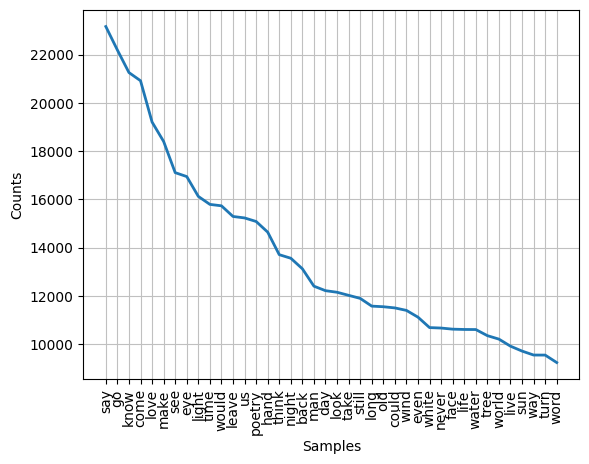

<Axes: xlabel='Samples', ylabel='Counts'>

In [40]:
counts.plot(40, cumulative=False)

Now we are going to see the number of tokens per poem

Average number of tokens per poem: 103.49411502452074


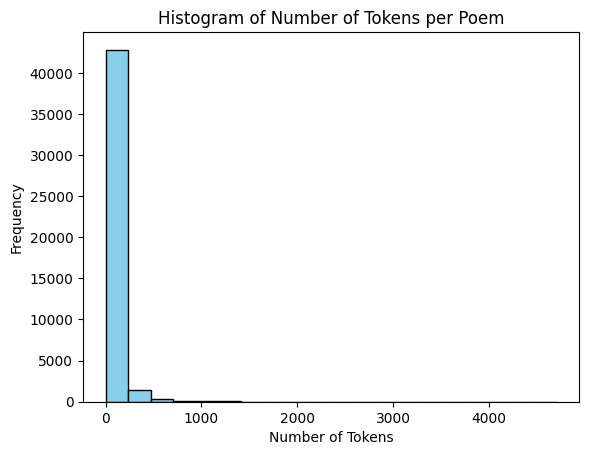

In [41]:
# Tokenize each poem and calculate the number of tokens
num_tokens_per_poem = [len(poem) for poem in corpus]

# Calculate the average number of tokens per poem
average_tokens_per_poem = sum(num_tokens_per_poem) / len(num_tokens_per_poem)
print("Average number of tokens per poem:", average_tokens_per_poem)


# Plot histogram
plt.hist(num_tokens_per_poem, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Tokens per Poem')
plt.show()

So we can see that most of the poems have around 103 tokens. Now we are going to use n-gramm detection to join tokens that appear together frequently.

In [42]:
phrase_model = Phrases(corpus, min_count=2, threshold=20)

print(colored('\n============= First poem in corpus =============', 'blue'))
print(corpus[0])
corpus = [el for el in phrase_model[corpus]] # We populate corpus again
print(colored('\n============= First poem after N-gram replacement =============', 'blue'))
print(corpus[0])


============= First poem in corpus =============
['free', 'without', 'ask', 'quick', 'delivery', 'via', 'overnight', 'male', 'special', 'handle', 'ten', 'year', 'incubation', 'lose', 'pound', 'two', 'weeks', 'cocktails', 'perrier', 'twist', 'azt', 'bactrim', 'broil', 'bacon', 'bits', 'egg', 'lipid', 'quiche', 'brunch', 'tongue', 'ablaze', 'toast', 'point', 'soundless', 'howl', 'talented', 'mind', 'best', 'body', 'generation', 'go', 'smoke', 'act', 'dial', 'get', 'operators', 'stand', 'photograph', 'prove', 'pass', 'away']

============= First poem after N-gram replacement =============
['free', 'without', 'ask', 'quick', 'delivery', 'via', 'overnight', 'male', 'special', 'handle', 'ten', 'year', 'incubation', 'lose', 'pound', 'two_weeks', 'cocktails', 'perrier', 'twist', 'azt', 'bactrim', 'broil', 'bacon', 'bits', 'egg', 'lipid', 'quiche', 'brunch', 'tongue', 'ablaze', 'toast', 'point', 'soundless', 'howl', 'talented', 'mind', 'best', 'body', 'generation', 'go', 'smoke', 'act', 'dial'

In [43]:
data['clean_tokens'] = corpus

To be able to work with the corpus, we need to vectorize all its documents. To do so, there are two steps we need to carry out:

- Calculate the dictionary
- Transform the documents using the dictionary

In [44]:
# Create dictionary of tokens
D = Dictionary(corpus)
n_tokens = len(D)

print('The positive dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The positive dictionary contains 140393 terms
First terms in the dictionary:
0 : ablaze
1 : act
2 : ask
3 : away
4 : azt
5 : bacon
6 : bactrim
7 : best
8 : bits
9 : body


Now we are going to filter tokens that appears just once in a poem, and then see what is the most common and less common tokens.

Number of tokens appearing in exactly one document: 61024
Most common token: go
Least common token: seagold


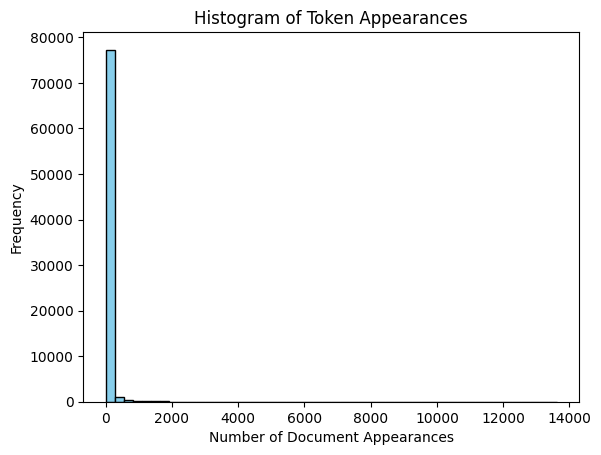

In [45]:
# Count the number of documents where each token appears
token_ndocs = {}
for doc in corpus:
    unique_tokens = set(doc)
    for token in unique_tokens:
        token_ndocs[token] = token_ndocs.get(token, 0) + 1

# Create DataFrame from token_ndocs
df_token_ndocs = pd.DataFrame(token_ndocs.items(), columns=['token', 'ndocs'])

# Sort the DataFrame by ndocs
df_token_ndocs_sorted = df_token_ndocs.sort_values(by='ndocs', ascending=False)

# Count tokens appearing in exactly one document
tokens_in_one_doc = df_token_ndocs_sorted[df_token_ndocs_sorted['ndocs'] == 1]
num_tokens_in_one_doc = len(tokens_in_one_doc)

# Remove tokens appearing in exactly one document
df_token_ndocs_filtered = df_token_ndocs_sorted[df_token_ndocs_sorted['ndocs'] > 1]

# Most and least common tokens
most_common_token = df_token_ndocs_filtered.iloc[0]['token']
least_common_token = df_token_ndocs_filtered.iloc[-1]['token']

print("Number of tokens appearing in exactly one document:", num_tokens_in_one_doc)
print("Most common token:", most_common_token)
print("Least common token:", least_common_token)

# Plot histogram of token appearances
plt.hist(df_token_ndocs_filtered['ndocs'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Number of Document Appearances')
plt.ylabel('Frequency')
plt.title('Histogram of Token Appearances')
plt.show()


Next, we will filter out terms that appear in too few or too many of the documents in the dataset. This makes sense because:

terms that appear in most documents are probably not very informative in the general context of a particular corpus
terms that appear in a very reduced number of documents are not useful to find repetitive patterns across documents. In fact, in many cases, we find that many of the words that are eliminated for this reason can be typos.

In [46]:
no_below = 10 # Minimum number of documents to keep a term in the dictionary
no_above = .75 # Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

The dictionary contains 22567 terms


In [47]:
corpus_def = []
for sent in corpus:
  aux = [token for token in sent if token in D.token2id.keys()]
  corpus_def.append(aux)

data['clean_tokens'] = corpus_def

In [48]:
data.head(5)

,title,author,categories,clean_tokens
0,The 80&rsquo;s Miracle Diet,By Melvin Dixon,"['Living', 'Health & Illness']","[free, without, ask, quick, delivery, via, ove..."
1,All Saints&rsquo;,By Corey Van Landingham,[],"[caravaggio, face, sink, pumpkin, bulbs, rot, ..."
2,And These Are Just a Few ...,By Melvin Dixon,"['Living', 'Health & Illness', 'Social Comment...","[poem, epidemic, dead, live, remember, neighbo..."
3,ASMR,By Corey Van Landingham,[],"[climb, mountain, delight, world, thin, meridi..."
4,ASMR,By Corey Van Landingham,[],"[hello, tonight, trace, static, bough, cool, s..."


## Bag-Of-Words (BoW)

Now we are going to create the BoW representation of our corpus

In [49]:
poems_bow = [D.doc2bow(doc) for doc in corpus]

n_poem = 1000
print(colored('============= Poem (lemmas) =============', 'blue'))
print(' '.join(corpus[n_poem]))

print(colored('\n============= Sparse vector representation =============', 'blue'))
print(poems_bow[n_poem])

print(colored('\n============= Word counts for the poem =============', 'blue'))
word_counts = list(map(lambda x: (D[x[0]], x[1]), poems_bow[n_poem]))
print(word_counts)

============= Poem (lemmas) =============
flesh breath soul begin rise eve_eve ness even balance man wo man even lord even eve begin yeses paradigm mourn sorrow door open another close prayers wish forever transform transformation life genealogy ways ways silver golden leave madrigal tree sing drift fall away tongue illuminate every man great forevermore small everyman heel souls bruise crucifixion resurrection transfiguration translations begin breath leave flesh yet consciousness mystery reform inform end reborn wish beginnings_end life eternity forever transform

============= Sparse vector representation =============
[(3, 1), (37, 1), (68, 3), (70, 1), (116, 3), (132, 2), (222, 1), (261, 1), (284, 1), (332, 1), (346, 1), (397, 1), (422, 1), (445, 1), (455, 1), (681, 1), (683, 1), (762, 2), (840, 2), (890, 1), (1134, 1), (1164, 1), (1199, 2), (1246, 1), (1281, 3), (1293, 2), (1379, 1), (1407, 1), (1614, 1), (1834, 2), (1875, 2), (2083, 1), (2595, 1), (2726, 1), (2793, 1), (3018, 1)

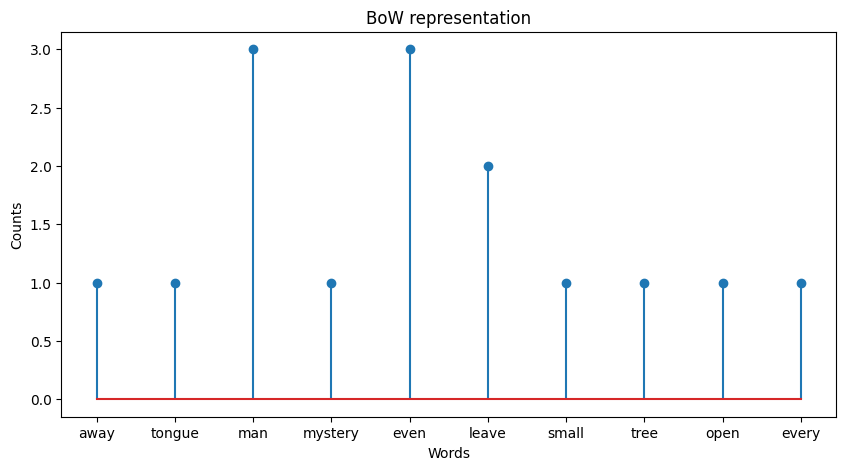

In [50]:
# Your list_word_counts
list_word_counts = [(D[doc_bow[0]], doc_bow[1]) for doc_bow in poems_bow[1000][:10]]

# Unzip the sorted list_word_counts
(words, counts) = zip(*list_word_counts)

# Plot the sorted BoW representation
plt.figure(figsize=(10,5))
# plt.stem(words, counts, use_line_collection=True)
plt.stem(words, counts)
plt.title("BoW representation")
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()

## TF-IDF vectorization

In [51]:
tfidf = TfidfModel(poems_bow)

In [52]:
poems_tfidf = tfidf[poems_bow]
n_poem = 1000
print(colored('============= TFIDF representation for the poem =============', 'blue'))
print(poems_tfidf[n_poem])

print(colored('\n============= TFIDF applying the transformation only to the document =============', 'blue'))
print(tfidf[poems_tfidf[n_poem]])

============= TFIDF representation for the poem =============
[(3, 0.050096798166969464), (37, 0.07129720996746516), (68, 0.13095476836460687), (70, 0.10797052232286695), (116, 0.12387731159534127), (132, 0.06989402458291327), (222, 0.05812360427211215), (261, 0.047357805403032034), (284, 0.05478902722892311), (332, 0.05372071347920703), (346, 0.13541441842590723), (397, 0.07008850147779812), (422, 0.06070573818613721), (445, 0.04994494759029588), (455, 0.11230918441909381), (681, 0.051633496882917455), (683, 0.05732584160895345), (762, 0.1357963152674313), (840, 0.1638649433529593), (890, 0.05674138043292383), (1134, 0.04848806429335477), (1164, 0.05484034902030801), (1199, 0.14554257349861754), (1246, 0.09144039235826827), (1281, 0.184750254178646), (1293, 0.08847422232217933), (1379, 0.06008029196383299), (1407, 0.14281833203149885), (1614, 0.08253127549760712), (1834, 0.15443712520433145), (1875, 0.26036822065612647), (2083, 0.07012688299817418), (2595, 0.07589448850516987), (2726,

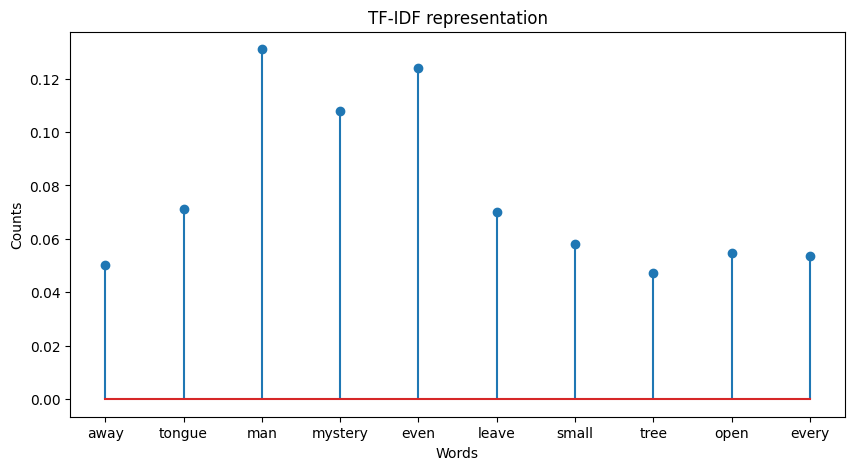

In [53]:
# Assuming you have a list of (word, count) tuples called list_word_counts
list_word_counts = [(D[doc_tf[0]], doc_tf[1]) for doc_tf in poems_tfidf[1000][:10]]

# Unzip the sorted list_word_counts
(words, counts) = zip(*list_word_counts)

# Plot the sorted BoW representation
plt.figure(figsize=(10,5))
# plt.stem(words, counts, use_line_collection=True)
plt.stem(words, counts)
plt.title("TF-IDF representation")
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()


## Word2Vec

In [54]:
phrase_model = Phrases(corpus)

corpus_phrases = list(phrase_model[corpus])

word2vec_model = Word2Vec(corpus_phrases, vector_size=100, window=5, min_count=5, seed=1, workers=1)

In [55]:
print(colored('\n============= Word2Vec vocabulary =============', 'blue'))
words = list(word2vec_model.wv.key_to_index)
print(words[0:10])
print(colored('\n============= Embedding of the first word =============', 'blue'))
print(word2vec_model.wv[words[0]])


============= Word2Vec vocabulary =============
['say', 'know', 'go', 'come', 'love', 'make', 'see', 'eye', 'light', 'would']

============= Embedding of the first word =============
[-0.61169785 -0.4201818   0.79168224  1.4139112   0.31985423 -2.3084562
  1.1919059   0.42257544 -0.9921099  -0.2398296   1.065536   -0.71602803
  3.5222242   0.6573235   0.98461    -0.24068248  0.8767167   0.4050285
 -3.633839   -1.4661195   0.8388431   0.7901061   1.2745996   0.6026589
 -0.20376751 -0.3120749  -0.79777056 -1.1811461  -0.08977471  0.2904676
  1.1110029   0.8963602   0.6103973  -0.99558586 -3.2160542  -0.78305024
  2.0799034  -1.2474351   0.7322852   0.7317091  -0.45967954  1.1556927
  2.5980544  -0.6848288  -1.9110214  -0.22944611  0.6532482   0.12902297
  0.02317865 -0.7346317 ]


In [56]:
word2vec_model.wv.most_similar("love")

[('tenderness', 0.6501989960670471),
 ('beauty', 0.6443984508514404),
 ('hate', 0.6422479152679443),
 ('lover', 0.6294284462928772),
 ('true', 0.6293812394142151),
 ('lovers', 0.6154146194458008),
 ('passion', 0.6061524748802185),
 ('loneliness', 0.6027901768684387),
 ('sadness', 0.6013476848602295),
 ('sarah_elizabeth_rodger', 0.5982157588005066)]

In [57]:
embeddings = word2vec_model.wv.vectors
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings)

# Plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(word2vec_model.wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

plt.grid()
plt.show()

KeyboardInterrupt: 

In [58]:
del(embed_tsne)  # To free memory

NameError: name 'embed_tsne' is not defined

## FastText

In [59]:
fasttext_model = FastText(sentences=corpus_phrases, vector_size=100, window=5, min_count=5, seed=1, workers=1)

In [60]:
fasttext_model.wv.most_similar("love")

[('unlove', 0.8741084933280945),
 ('loveth', 0.8733625411987305),
 ('lover', 0.8732479214668274),
 ('love_hate', 0.865572988986969),
 ('lover_lover', 0.8490788340568542),
 ('lov_lov', 0.84805828332901),
 ('dearly_love', 0.8458705544471741),
 ('lov', 0.834928035736084),
 ('love_supreme', 0.8242701292037964),
 ('lover_former', 0.8190270662307739)]

FastText is giving a best similarities than Word2Vec

In [ ]:
embeddings = fasttext_model.wv.vectors
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings)

# Plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(fasttext_model.wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

plt.grid()
plt.show()

## Topic modeling with LDA

In [ ]:
# Specify the number of topics to try
num_topics_list = [5, 10, 15, 20, 25]

# Compute coherence scores for different number of topics
coherence_scores = []
for num_topics in num_topics_list:
    lda_model = LdaModel(corpus=poems_bow, id2word=D, num_topics=num_topics)
    coherence_model = CoherenceModel(model=lda_model, texts=corpus_phrases, dictionary=D, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append((num_topics, coherence_score))

# Select the optimal number of topics based on coherence score
optimal_num_topics, optimal_coherence_score = max(coherence_scores, key=lambda x: x[1])
print(f"Optimal number of topics: {optimal_num_topics}, Coherence score: {optimal_coherence_score}")

# Train the final LDA model with the optimal number of topics
final_lda_model = LdaModel(corpus=poems_bow, id2word=D, num_topics=optimal_num_topics)


In [ ]:
# Extract number of topics and coherence scores
num_topics_list, coherence_scores = zip(*coherence_scores)

# Plot coherence scores
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, coherence_scores, marker='o', linestyle='-')
plt.title('Coherence Score vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_list)
plt.grid(True)
plt.show()

In [ ]:
# Get top words for each topic
topics = final_lda_model.show_topics(formatted=False)

# Sort topics based on topic ID
topics.sort(key=lambda x: x[0])

# Create a figure and axis for subplots
fig, axes = plt.subplots(5, 3, figsize=(15, 25))

# Plot WordCloud for each topic
for i, (topic_id, topic) in enumerate(topics):
    row = i % 5  # Calculate the row index
    col = i // 5  # Calculate the column index
    word_freq = dict(topic)
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_freq)
    axes[row, col].imshow(wordcloud, interpolation='bilinear')
    axes[row, col].set_title(f'Topic {topic_id}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Define the range of num_topics to try
num_topics_to_try = [5, 10, 15, 20, 25]

# Loop through each num_topics and generate word clouds
for num_topics in num_topics_to_try:
    ldag = LdaModel(corpus=poems_bow, id2word=D, num_topics=num_topics)  # Create LDA model

    # Create a figure and axes for plotting
    num_rows = (num_topics - 1) // 5 + 1  # Calculate the number of rows for subplots
    fig, axes = plt.subplots(num_rows, 5, figsize=(16, 4 * num_rows), sharex=True, sharey=True)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Loop through each topic and generate a word cloud for it
    for i, ax in enumerate(axes):
        # Calculate the starting topic number for the current subplot
        topic_num = i

        if topic_num < num_topics:  # Check if the topic index is within bounds
            # Build a dataframe with columns 'token' and 'weight' for the current topic
            topic_tokens = ldag.show_topic(topic_num, topn=10)
            df = pd.DataFrame(topic_tokens, columns=['token', 'weight'])

            # Convert the top words to a dictionary for word cloud generation
            wordcloud_dict = {row['token']: row['weight'] for _, row in df.iterrows()}

            # Generate the word cloud
            wordcloud = WordCloud(width=200, height=200, background_color='white').generate_from_frequencies(wordcloud_dict)

            # Plot the word cloud on the current subplot
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title('Topic ' + str(topic_num))
            ax.axis('off')

    fig.suptitle('Number of Topics: ' + str(num_topics), fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to avoid overlap
    plt.show()


In [ ]:
topn = 25

fig, axes = plt.subplots(4, 5, figsize=(16, 16), sharex=True)

for i in range(4):
    for j in range(5):
        # Calculate the starting topic number for the current subplot
        topic_num = i * 5 + j

        # Build a dataframe with columns 'token' and 'weight' for the current topic
        topic_tokens = ldag.show_topic(topic_num, topn=topn)
        df = pd.DataFrame(topic_tokens, columns=['token', 'weight'])

        # Plot the top words for the current topic
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title('Topic ' + str(topic_num))

plt.tight_layout()
plt.show()

In [ ]:
# Create a figure and axes for plotting
fig, axes = plt.subplots(4, 5, figsize=(16, 16), sharex=True)

# Loop through each topic and generate a word cloud for it
for i in range(4):
    for j in range(5):
        # Calculate the starting topic number for the current subplot
        topic_num = i * 5 + j

        # Build a dataframe with columns 'token' and 'weight' for the current topic
        topic_tokens = ldag.show_topic(topic_num, topn=topn)
        df = pd.DataFrame(topic_tokens, columns=['token', 'weight'])

        # Convert the top words to a dictionary for word cloud generation
        wordcloud_dict = {row['token']: row['weight'] for index, row in df.iterrows()}

        # Generate the word cloud
        wordcloud = WordCloud(width=200, height=200, background_color='white').generate_from_frequencies(wordcloud_dict)

        # Plot the word cloud on the current subplot
        ax = axes[i][j]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title('Topic ' + str(topic_num))
        ax.axis('off')

plt.tight_layout()
plt.show()

# Classification Dataset Preprocessing

In [61]:
if COLLAB:
    df = pd.read_csv('/content/drive/MyDrive/classification_data.csv', encoding='latin-1')
else:
    df = pd.read_csv('Datasets/classification_data.csv', encoding='latin-1', dtype=str)

# Drop rows with missing values in the 'poem' column
df = df.dropna(subset=['poem'])

In [62]:
df.head()

,id,title,author,snippet,link,categories,period,poem
0,43926,The Canterbury Tales: General Prologue,By Geoffrey Chaucer,Whan that Aprille with his shour<strong>e</str...,https://www.poetryfoundation.org/poems/43926/t...,"['The Body', 'The Mind', 'Love', 'Activities',...",Middle English,Here bygynneth the Book of the tales of Caunte...
1,44295,"Confessio Amantis, Book III: The Tale of Apoll...",By John Gower,"Appolinus his levE tok,",https://www.poetryfoundation.org/poems/44295/c...,[],Middle English,"Appolinus his leve tok, To God and al the lond..."
2,159137,Ego Dormio: [All perishes and passes],By Richard Rolle,[Alle perisches and passes pat we with eghe see],https://www.poetryfoundation.org/poems/159137/...,"['Love', 'Classic Love', 'Religion', 'Christia...",Middle English,[Alle perisches and passes pat we with eghe se...
3,44442,The King&#39;s Quire,"By James I, Of Scotland","Bewailing in my chamber thus allone,",https://www.poetryfoundation.org/poems/44442/t...,[],Middle English,"Bewailing in my chamber thus allone, Despeired..."
4,43936,The Parlement of Fowls,By Geoffrey Chaucer,"Now welcome, somer, with thy sonne soft<b>e</b>,",https://www.poetryfoundation.org/poems/43936/t...,"['Love', 'Romantic Love', 'Relationships', 'Na...",Middle English,"(excerpt) Now welcome, somer, with thy sonne s..."


In [63]:
columns_to_drop = ["id", "snippet", "link"]
df.drop(columns=columns_to_drop, inplace=True)

In [64]:
df.head()

,title,author,categories,period,poem
0,The Canterbury Tales: General Prologue,By Geoffrey Chaucer,"['The Body', 'The Mind', 'Love', 'Activities',...",Middle English,Here bygynneth the Book of the tales of Caunte...
1,"Confessio Amantis, Book III: The Tale of Apoll...",By John Gower,[],Middle English,"Appolinus his leve tok, To God and al the lond..."
2,Ego Dormio: [All perishes and passes],By Richard Rolle,"['Love', 'Classic Love', 'Religion', 'Christia...",Middle English,[Alle perisches and passes pat we with eghe se...
3,The King&#39;s Quire,"By James I, Of Scotland",[],Middle English,"Bewailing in my chamber thus allone, Despeired..."
4,The Parlement of Fowls,By Geoffrey Chaucer,"['Love', 'Romantic Love', 'Relationships', 'Na...",Middle English,"(excerpt) Now welcome, somer, with thy sonne s..."


### Separate Languages, filter out non-english poems

In [65]:
# Call the function to separate language
classif_english_df, classif_other_lang_df = separate_language(df, 'poem')

In [66]:
# i want to check the size of both dfs
print(classif_english_df.shape)
print(classif_other_lang_df.shape)

(5525, 5)
(7, 5)


As before, the proportion of non-english poems is pretty low, and here we only have 8 of them. As we have the english translated version already in the data, we remove can them.

In [67]:
classif_english_df.head()

,title,author,categories,period,poem
0,The Canterbury Tales: General Prologue,By Geoffrey Chaucer,"['The Body', 'The Mind', 'Love', 'Activities',...",Middle English,Here bygynneth the Book of the tales of Caunte...
1,"Confessio Amantis, Book III: The Tale of Apoll...",By John Gower,[],Middle English,"Appolinus his leve tok, To God and al the lond..."
2,Ego Dormio: [All perishes and passes],By Richard Rolle,"['Love', 'Classic Love', 'Religion', 'Christia...",Middle English,[Alle perisches and passes pat we with eghe se...
3,The King&#39;s Quire,"By James I, Of Scotland",[],Middle English,"Bewailing in my chamber thus allone, Despeired..."
4,The Parlement of Fowls,By Geoffrey Chaucer,"['Love', 'Romantic Love', 'Relationships', 'Na...",Middle English,"(excerpt) Now welcome, somer, with thy sonne s..."


In [68]:
classif_other_lang_df.head()

,title,author,categories,period,poem
3090,"""Lettres d'un Soldat""",By Wallace Stevens,[],Modern,"PBoetry ett get MAY, 1918 LETTRES DUN SOL..."
3579,The Song of the Nightingale is Like the Scent ...,By Mina Loy,"['Relationships', 'Pets', 'Nature', 'Animals',...",Modern,Nightingale singinggale of Nanking Singmystery...
4156,The Murder of Two Men by a Young Kid Wearing L...,By Kenneth Patchen,"['Living', 'Death', 'Social Commentaries', 'Cr...",Beat,Wait. Wait. Wait. Wait. Wait. Wait. Wait. W a ...
5367,"(""car swerves..."")",By Aram Saroyan,[],New York School (2nd Generation),"ARAM SAROYAN jruinsgilje car swerves, injure..."
5429,"(""j;u;n;g;l;e;..."")",By Aram Saroyan,[],New York School (2nd Generation),"ARAM SAROYAN jruinsgilje car swerves, injure..."


### Save the Classification English DataFrame

In [69]:
classif_english_df.to_csv('classif_english_df.csv', encoding='latin-1', index=False,errors = "ignore", quoting=1) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used

#other languages dataset can not be codified and as we are not going to use it we dont care about it
classif_other_lang_df.to_csv('classif_other_lang_df.csv',encoding='latin-1', index=False) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used

In [154]:
df = pd.read_csv('classif_english_df.csv', encoding='latin-1')

In [71]:
df2 = df.copy()
df2['poem'] = df['poem'].apply(lambda x: wrangle_text(x))

<ipython-input-18-ea636bf75af2>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [72]:
# Apply the prepare_data function to clean the poems
df2['clean_tokens'] = df2['poem'].apply(lambda x: prepare_data(x, tool='lemmatize'))

In [73]:
df2.head()

,title,author,categories,period,poem,clean_tokens
0,The Canterbury Tales: General Prologue,By Geoffrey Chaucer,"['The Body', 'The Mind', 'Love', 'Activities',...",Middle English,Here bygynneth the Book of the tales of Caunte...,"[bygynneth, book, tales, caunterbury, whan, ap..."
1,"Confessio Amantis, Book III: The Tale of Apoll...",By John Gower,[],Middle English,Appolinus his leve tok To God and al the lond ...,"[appolinus, leve, tok, god, al, lond, betok, a..."
2,Ego Dormio: [All perishes and passes],By Richard Rolle,"['Love', 'Classic Love', 'Religion', 'Christia...",Middle English,Alle perisches and passes pat we with eghe see...,"[alle, perisches, pass, pat, eghe, see, wan, w..."
3,The King&#39;s Quire,"By James I, Of Scotland",[],Middle English,Bewailing in my chamber thus allone Despeired ...,"[bewail, chamber, thus, allone, despeired, joy..."
4,The Parlement of Fowls,By Geoffrey Chaucer,"['Love', 'Romantic Love', 'Relationships', 'Na...",Middle English,excerpt Now welcome somer with thy sonne softe...,"[excerpt, welcome, somer, thy, sonne, softe, h..."


In [75]:
df2.to_csv('classification_processed.csv', encoding='latin-1', index=False, quoting=1) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used

# Classification task

In [153]:
data = pd.read_csv('classification_processed.csv', encoding='latin-1')

Lets see how many observations of each class we have:

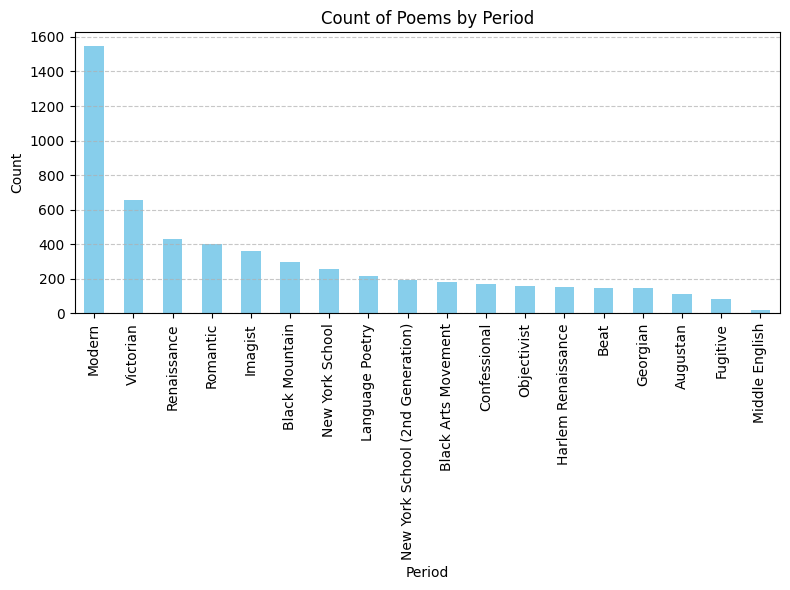

In [77]:
period_counts = data['period'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
period_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Poems by Period')
plt.xlabel('Period')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [78]:
class_percentages = data['period'].value_counts(normalize=True) * 100

print(class_percentages)

period
Modern                              28.036199
Victorian                           11.837104
Renaissance                          7.764706
Romantic                             7.294118
Imagist                              6.497738
Black Mountain                       5.375566
New York School                      4.597285
Language Poetry                      3.963801
New York School (2nd Generation)     3.529412
Black Arts Movement                  3.239819
Confessional                         3.076923
Objectivist                          2.841629
Harlem Renaissance                   2.733032
Beat                                 2.660633
Georgian                             2.642534
Augustan                             2.063348
Fugitive                             1.538462
Middle English                       0.307692
Name: proportion, dtype: float64


### Build the corpus

In [79]:
clean_tokens =  data['clean_tokens'].apply(ast.literal_eval)

# Convert the pandas series to a list of lists
corpus = clean_tokens.tolist()

In [80]:
phrase_model = Phrases(corpus)

corpus_phrases = list(phrase_model[corpus])

### Split into train and test

In [182]:
corpus_train, corpus_val, y_train, y_val= train_test_split(corpus,data['period'].values, test_size=0.3, random_state = 1)

BOW representation

In [82]:
# BoW split
bow_train = [D.doc2bow(doc) for doc in corpus_train]
bow_val = [D.doc2bow(doc) for doc in corpus_val]

In [83]:
# In order to use the BoW for the classification task, we first need to obtain
# its dense representation
bow_train_dense = corpus2dense(bow_train, num_terms=n_tokens, num_docs=len(bow_train)).T
bow_train_sparse = corpus2csc(bow_train, num_terms=n_tokens, num_docs=len(bow_train)).T

bow_val_dense = corpus2dense(bow_val, num_terms=n_tokens, num_docs=len(bow_val)).T
bow_val_sparse = corpus2csc(bow_val, num_terms=n_tokens, num_docs=len(bow_val)).T

TF-IDF representation

In [84]:
# TFIDF split
model_train = TfidfModel(bow_train)
model_val = TfidfModel(bow_val)

# apply models to the poems
tfidf_train = model_train[bow_train]
tfidf_val = model_val[bow_val]

In [85]:
# Obtain dense and sparse representations for the TFIDF
tfidf_train_dense = corpus2dense(tfidf_train, num_terms=n_tokens, num_docs=len(bow_train)).T
tfidf_val_dense = corpus2dense(tfidf_val, num_terms=n_tokens, num_docs=len(bow_val)).T

tfidf_train_sparse = corpus2csc(tfidf_train, num_terms=n_tokens, num_docs=len(bow_train)).T
tfidf_val_sparse = corpus2csc(tfidf_val, num_terms=n_tokens, num_docs=len(bow_val)).T

Word2Vec representation

In [183]:
word2vec_model = Word2Vec(corpus_train, vector_size=100, window=5, min_count=5, seed=1, workers=1)

In [184]:
# Prepare training data
X_train_word2vec = []
for document in corpus_train:
    doc_vector = np.mean([word2vec_model.wv[word] for word in document if word in word2vec_model.wv], axis=0)
    X_train_word2vec.append(doc_vector)

# Split data into train and test sets
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_train_word2vec, y_train, test_size=0.2, random_state=42)

FastText representation VER COMO HACER Q FUNCIONE EN UN MODELO

In [188]:
FT_model = FastText(corpus_train, vector_size=100, window=5, min_count=5, seed=1, workers=1)

In [189]:
# Prepare training data
X_train_ft = []
for document in corpus_train:
    doc_vector = np.mean([FT_model.wv[word] for word in document if word in FT_model.wv], axis=0)
    X_train_ft.append(doc_vector)

# Split data into train and test sets
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X_train_ft, y_train, test_size=0.2, random_state=42)

Pre-trained model

In [ ]:
nlp = spacy.load('en_core_web_md')
embs_FT = [nlp(df.loc[idx_em, 'poem']).vector for idx_em in df.index.values]

In [ ]:
# Fast Text
embs_FT_train, embs_FT_val, y_train_ft, y_val_ft= train_test_split(embs_FT,df['period'].values, test_size=0.3, random_state = 40)  # random_state=10

### Param grid for the models

In [91]:
# Set grid search params
param_range = range(5, 35, 10)

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
		'clf__max_depth': param_range}]

grid_params_svm = [{'clf__kernel': ['rbf'],
		'clf__C': [1, 10]}]

grid_params_knn = {
    'kNN__n_neighbors': range(5,40, 10),
    'kNN__weights':['uniform','distance'],
}

# number of jobs in the GridSearch
jobs = -1

In [92]:
# Construct some pipelines

pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=42))])

pipe_svm = Pipeline([('clf', SVC(random_state=42))])

pipe_knn = Pipeline([('kNN', KNeighborsClassifier())])



# Construct grid searches

gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=5,
			n_jobs=jobs, verbose=2)

gs_svm = GridSearchCV(estimator=pipe_svm,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=5,
			n_jobs=jobs, verbose=2)

gs_knn = GridSearchCV(estimator=pipe_knn,
			param_grid=grid_params_knn,
			scoring='accuracy',
			cv=5,
			n_jobs=jobs, verbose=2)

We will safe the accuracies in the following dataframe

In [93]:
results = pd.DataFrame(columns=['vectorization', 'acc', 'method'])

## Training the models

Lets see the perfomance with the BOW representation:

In [116]:
gs_rf.fit(bow_train_dense, y_train)
y_pred = gs_rf.predict(bow_val_dense)
results["vectorization"] = "BoW"
results["acc"] = accuracy_score(y_val, y_pred)
results["method"] = "RF"

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [117]:
gs_svm.fit(bow_train_sparse, y_train)
y_pred = gs_svm.predict(bow_val_sparse)
results["vectorization"] = "BoW"
results["acc"] = accuracy_score(y_val, y_pred)
results["method"] = "SVM"

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [118]:
gs_knn.fit(bow_train_dense, y_train)
y_pred = gs_knn.predict(bow_val_dense)
results["vectorization"] = "BoW"
results["acc"] = accuracy_score(y_val, y_pred)
results["method"] = "KNN"

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Lets see the perfomance with the TF-IDF representation

In [186]:
gs_rf.fit(tfidf_train_dense, y_train)
y_pred = gs_rf.predict(tfidf_val_dense)
results["vectorization"] = "TF-IDF"
results["acc"] = accuracy_score(y_val, y_pred)
results["method"] = "RF"

Fitting 5 folds for each of 6 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
gs_svm.fit(tfidf_train_sparse, y_train)
y_pred = gs_svm.predict(tfidf_val_sparse)
results["vectorization"] = "TF-IDF"
results["acc"] = accuracy_score(y_val, y_pred)
results["method"] = "SVM"

In [ ]:
gs_knn.fit(tfidf_train_dense, y_train)
y_pred = gs_knn.predict(tfidf_val_dense)
results["vectorization"] = "TF-IDF"
results["acc"] = accuracy_score(y_val, y_pred)
results["method"] = "KNN"

Lets see the performance with word2vec

In [187]:
# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_w2v, y_train_w2v)

# Evaluate on test set
y_pred = rf_classifier.predict(X_test_w2v)
accuracy = accuracy_score(y_test_w2v, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.3875968992248062


Lets see the performance for fastText

In [190]:
# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_ft, y_train_ft)

# Evaluate on test set
y_pred = rf_classifier.predict(X_test_ft)
accuracy = accuracy_score(y_test_ft, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.36046511627906974


Lets see the performance with pre-trained model

In [163]:
gs_knn.fit(embs_FT_train, y_train_ft)
rf_test_score = gs_knn.score(embs_FT_val, y_val_ft)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


ValueError: X has 300 features, but RandomForestClassifier is expecting 22567 features as input.

## Reducing the dimensionalty

In the previous section, a premiliminary analysis regarding the best algorithm and data representation was carried out. We concluded that the combination with highest accuracy was the Fast Text representation combined with Random Forest. Thus, we will continue working with it. However, in order to try to improve the prediction and computational results, we will perform first feature extraction and then feature selection. By doing this, we will keep most of the relevance of the data, while reducing dimensionality and keeping only those valuable variables. Regarding the feature extraction techniques, in this case we opt for supervised approaches, in addition to PCA.

The techniques that we will perform in Feature extraction are:


*   Canonical Correlation analysis
*   Linear Discriminant Analysis
*   PCA

Then, the technique that will be used for feature selection is:

*   Mutual information